### Richard Ogundele -- 22539744


### ADVANCED MACHINE LEARNING

In [1]:
#!pip install --upgrade scikit-learn -q --user

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(
    style='ticks', 
    context='talk',
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)}
)
import random
random.seed(24)
np.random.seed(24)

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from numpy import percentile

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)


### DATA PROCESSING FOR MACHINE LEARNING

In [4]:
adv = pd.read_csv('adverts.csv')
adv.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [5]:
adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [6]:
def data_distribution(col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].hist(col)
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("{col}")

    sns.boxplot(x=col, ax=ax[1])
    ax[1].set_xlabel("Value")
    ax[1].set_ylabel("")
    fig.suptitle('Data Distribution')
    plt.show()

In [7]:
def outlier_removal(col):
    Q25, Q50, Q75 = percentile(col,25), percentile(col, 50),percentile(col, 75)
    print('25th percentile:', Q25, '50th percentile: ', Q50, '75th percentile: ', Q75)
    IqR = Q75 - Q25
    #calculate cutoff outlier
    cutoff = IqR * 1.5
    lower_lim, upper_lim = Q25 - cutoff, Q75 + cutoff
    adv[(col < lower_lim) | (col > upper_lim)]
    outliers = [i for i in col if i < lower_lim or i > upper_lim]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    adv.drop(adv[(col > upper_lim) | (col < lower_lim)].index, inplace=True)
    outliers_removed = [i for i in col if i >= lower_lim and i <= upper_lim]
    print('Non-outlier observations: %d' % len(outliers_removed))
    
    colx = col < upper_lim

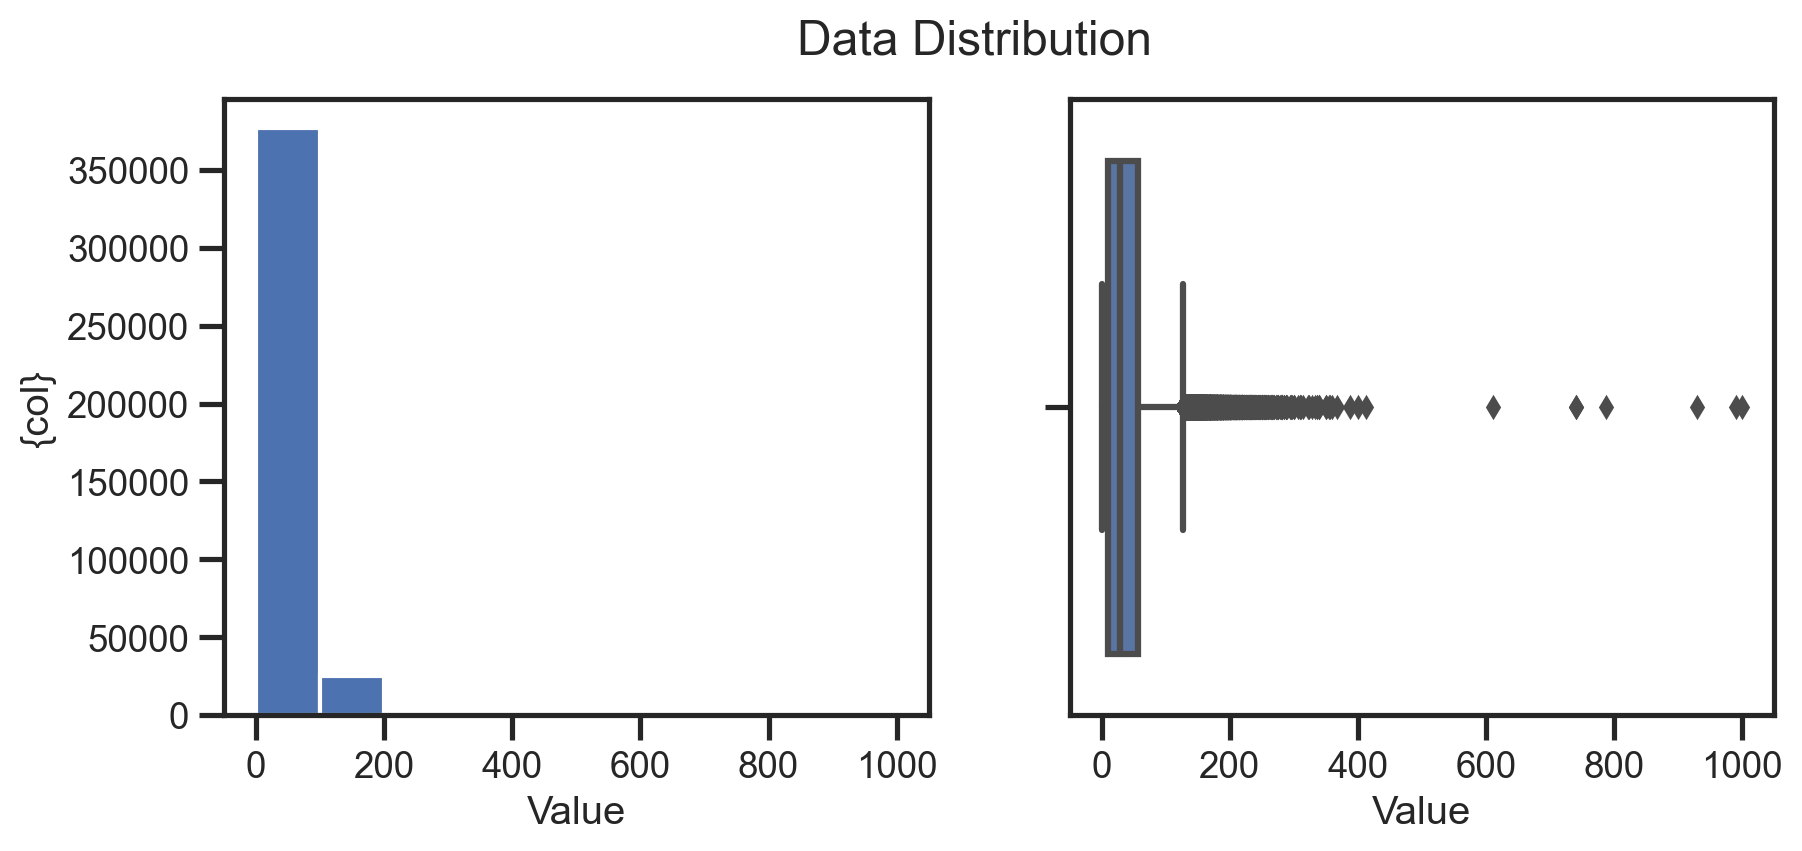

In [8]:
data_distribution(adv['mileage']/1000)

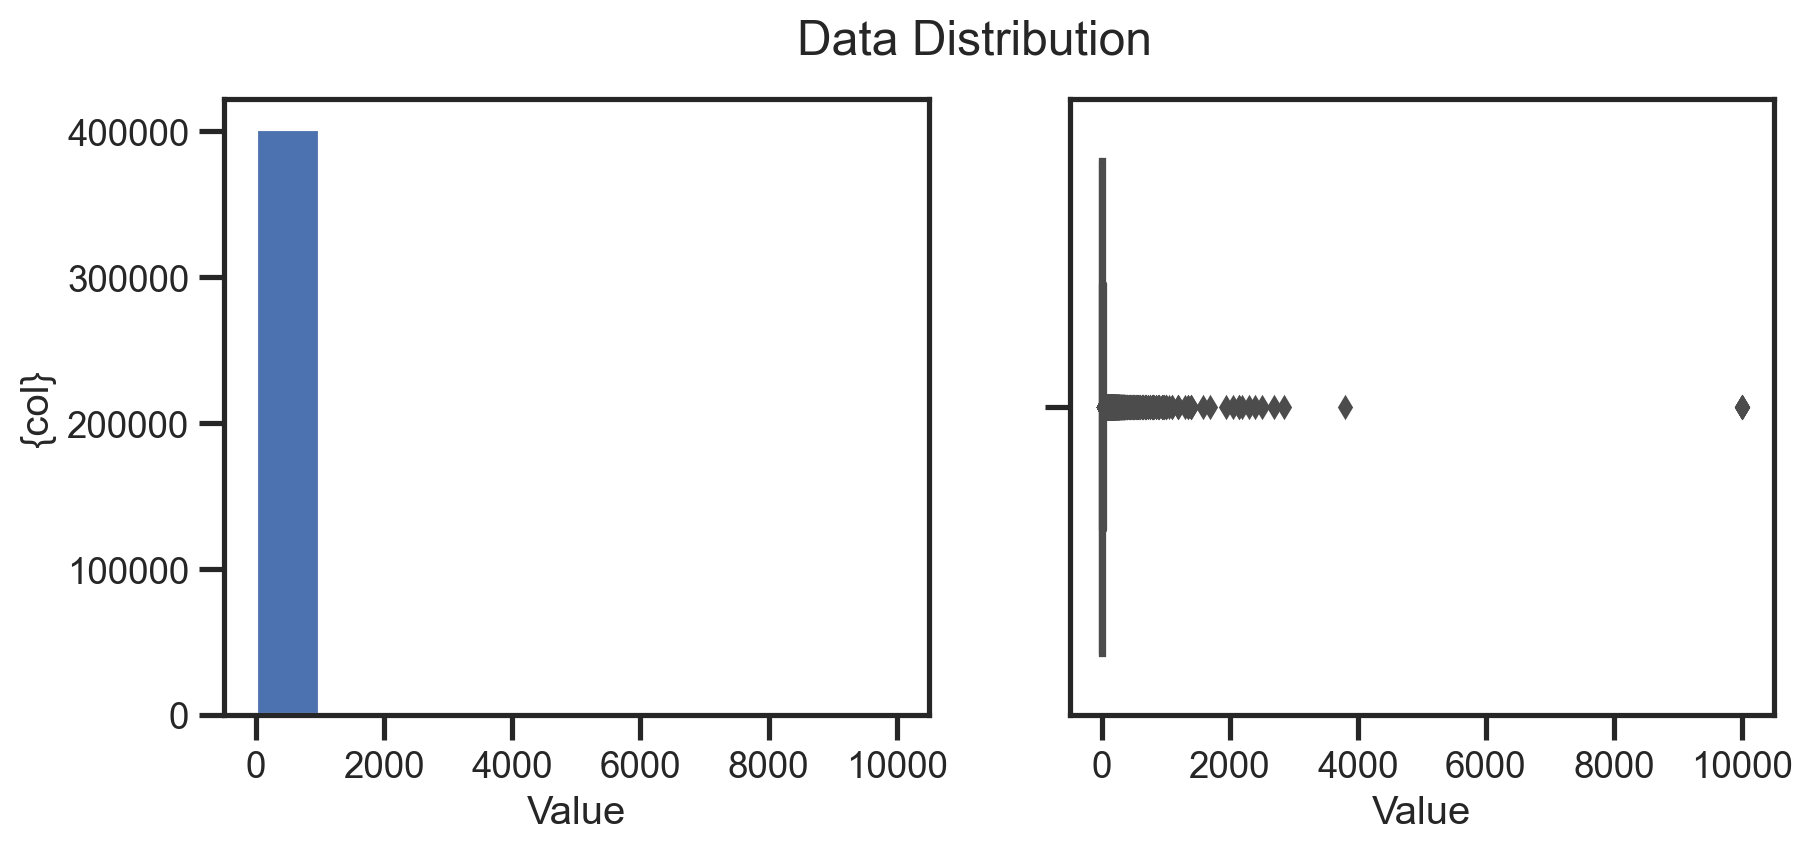

In [9]:
data_distribution(adv['price']/1000)

In [10]:
cols = ['mileage','year_of_registration', 'public_reference', 'price']
for col in cols:
    print(col.upper())
    outlier_removal(adv[col])
    print('-'*20)

MILEAGE
25th percentile: nan 50th percentile:  nan 75th percentile:  nan
Identified outliers: 0
Non-outlier observations: 0
--------------------
YEAR_OF_REGISTRATION
25th percentile: nan 50th percentile:  nan 75th percentile:  nan
Identified outliers: 0
Non-outlier observations: 0
--------------------
PUBLIC_REFERENCE
25th percentile: 202009023197699.0 50th percentile:  202009304400624.0 75th percentile:  202010175124399.0
Identified outliers: 54649
Non-outlier observations: 347356
--------------------
PRICE
25th percentile: 7390.0 50th percentile:  12300.0 75th percentile:  19450.0
Identified outliers: 20956
Non-outlier observations: 326400
--------------------


### FEATURE ENGINEERING

In [11]:
adv.drop(['reg_code', 'public_reference'], axis=1, inplace=True)

In [12]:
#determing that the new cars have no registration number yet
adv.loc[adv['vehicle_condition'] == 'NEW', 'year_of_registration'] = 0

In [13]:
#change categorical data in this column: crossover_car_and_van to int = LabelEncoder()
adv['crossover_car_and_van'] = adv['crossover_car_and_van'].map({False:0, True:1})

#change categorical data in this columns to integers and replaces used with 0 and new with 1
adv['vehicle_condition'] = adv['vehicle_condition'].map({"USED":0, "NEW":1})

adv.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
5,16000.0,Blue,Audi,S5,0,2017.0,29000,Convertible,0,Petrol
7,99000.0,Bronze,Land Rover,Range Rover,0,2013.0,24475,SUV,0,Diesel
8,111236.0,Black,Mercedes-Benz,S Class,0,2008.0,6995,Limousine,0,Diesel
12,4765.0,White,SKODA,Octavia,0,2019.0,16990,Estate,0,Petrol
13,18214.0,Silver,SEAT,Leon,0,2019.0,14290,Hatchback,0,Petrol


In [14]:
adv.dropna(axis=0, subset=None, inplace=True)
advert = adv.sample(frac=0.1)

In [15]:
len(advert)

32069

In [16]:
X, y = advert.drop(columns='price'), advert['price']

In [17]:
enc = LabelEncoder()
scaler = StandardScaler()
#use target encoder for all categorical data

cat_cols = ['standard_colour','standard_make','body_type']

X[cat_cols]= X[cat_cols].apply(enc.fit_transform)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
       ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()),
        ("poly_int", PolynomialFeatures(degree=2, include_bias=False))
    ]
)#.set_output(transform='pandas')
print(numeric_features)
numeric_transformer

['mileage', 'standard_colour', 'standard_make', 'vehicle_condition', 'year_of_registration', 'body_type', 'crossover_car_and_van']


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('poly_int', PolynomialFeatures(include_bias=False))])

In [20]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        #("ohe", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary'))
    ]
)#.set_output(transform='pandas')

categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)#.set_output(transform="pandas")

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('poly_int',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['mileage', 'standard_colour', 'standard_make',
                                  'vehicle_condition', 'year_of_registration',
                                  'body_type', 'crossover_car_and_van']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['standard_model', 'fuel_type'])],
                  verbose_feature_names_out=False)

### FEATURE SELECTION AND DIMENSIONALITY REDUCTION

In [22]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
         ("featsel", RFECV(Ridge(), step=1, cv=5)),
        #("featsel", SelectKBest(f_regression, k=10)),
        ("regr", Ridge())
    ]
)#.set_output(transform="pandas")

In [23]:
X_train.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,body_type,crossover_car_and_van,fuel_type
385938,10960.0,16,27,Picanto,0,2017.0,5,0,Petrol
136572,22000.0,18,12,C1,0,2013.0,5,0,Petrol
125695,54000.0,8,57,Corsa,0,2013.0,5,0,Petrol
22745,0.0,2,19,500,1,0.0,5,0,Petrol
371488,67450.0,16,37,C Class,0,2015.0,12,0,Diesel


In [ ]:
regr_pipe.fit(X_train, y_train)

In [ ]:
# Get the names of the selected features
selected_features = regr_pipe['featsel'].get_feature_names_out()

In [ ]:
regr_pipe['featsel'].transform(
    regr_pipe['preprocessor'].transform(X_train)
)

In [ ]:
regr_pipe.score(X_test, y_test)

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

In [ ]:
# scores = cross_val_score(
#     regr_pipe, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'
# )*-1
# scores.mean(), scores.std()

In [ ]:
n_scores = len(regr_pipe['featsel'].cv_results_["mean_test_score"])
n_scores

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    regr_pipe['featsel'].cv_results_["mean_test_score"],
    yerr=regr_pipe['featsel'].cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [ ]:
X_train.isna().sum()

In [ ]:
X_scaled = scaler.fit_transform(X_train)

# Apply PCA to reduce dimensionality
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.fit_transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Cumulative explained variance ratio
cumulative_explained_var_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio:", cumulative_explained_var_ratio)

In [ ]:
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### MODEL BUILDING

A Linear Model

In [ ]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regr", Ridge(alpha=10))
    ]
)#.set_output(transform="pandas")

regr_pipe.fit(X_train,y_train)

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

A Random Forest

In [ ]:
randomforest = Pipeline( 
    steps=[ ("preprocessor", preprocessor), 
           ("regr", RandomForestRegressor(max_depth=12, 
                                          min_samples_split=10, 
                                          min_samples_leaf=8))])

randomforest.fit(X_train, y_train) 

In [ ]:
rmse(y_test, randomforest.predict(X_test))

A Boosted Tree

In [ ]:
boosted_tree = Pipeline( 
    steps=[ ("preprocessor", preprocessor), 
           ("regr", HistGradientBoostingRegressor())])

boosted_tree.fit(X_train, y_train)

In [ ]:
rmse(y_test, boosted_tree.predict(X_test))

An Averager/Voter/Stacker Ensemble

In [ ]:
estimators = [('rd', Ridge()),
              ('lr', LinearRegression())]

ensemble = Pipeline( 
    steps=[ ("preprocessor", preprocessor), 
           ("regr", StackingRegressor(estimators=estimators,
                                      final_estimator=RandomForestRegressor(n_estimators=10,random_state=42)))])

ensemble.fit(X_train, y_train)

In [ ]:
rmse(y_test, ensemble.predict(X_test))

In [ ]:
# Evaluate the ensemble on the testing data
y_pred = ensemble.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Ensemble MSE:", mse)

In [ ]:
# cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
# print("Ensemble Cross-Validation MSE:", -cv_scores.mean())
# print(f"Cross_val_score Root Mean Squared Error: {scores.mean()*-1}")
# print(f"Standard deviation of the scores: {scores.std()}")

In [ ]:
# pipe = Pipeline(steps=
#     [
#         ('pp', StandardScaler()),
#         ('est', Ridge())
#     ]
# ).set_output(transform="pandas")

# param_grid = dict(regr__alpha=np.logspace(-3, 3, 7))

# grid = GridSearchCV(
#     pipe, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True
# )

In [ ]:
#grid.fit(X_train, y_train)

### MODEL EVALUATION AND ANALYSIS

In [ ]:
!pip install -q shap

In [ ]:
import shap
shap.initjs()

Overall Performance with Cross-Validation

In [ ]:
#Use cross-validation to estimate the performance of the linear regression model
scores = cross_val_score(regr_pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross_val_score Root Mean Squared Error: {scores.mean()*-1}")
print(f"Standard deviation of the scores: {scores.std()}")

In [ ]:
# Use cross-validation to estimate the performance of the random forest model
scores = cross_val_score(randomforest, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross_val_score Root Mean Squared Error: {scores.mean()*-1}")
print(f"Standard deviation of the scores: {scores.std()}")

In [ ]:
# # Use cross-validation to estimate the performance of the boosted tree model
scores = cross_val_score(boosted_tree, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross_val_score Root Mean Squared Error: {scores.mean()*-1}")
print(f"Standard deviation of the scores: {scores.std()}")

In [ ]:
# scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
# print(f"Cross_val_score Root Mean Squared Error: {scores.mean()*-1}")
# print(f"Standard deviation of the scores: {scores.std()}")

True vs Predicted Analysis

In [ ]:
def plot_true_vs_predicted(
        regr_pipe, 
        X_train, y_train,
        X_test, y_test,
        ax=None,
        train_style_kws={},
        test_style_kws={}
    ):
    if ax is None:
        fig, ax = plt.subplots()
    y_pred_train = regr_pipe.predict(X_train)
    y_pred_test = regr_pipe.predict(X_test)
    ax.plot(y_train, y_pred_train, '.', label='train', **train_style_kws)
    ax.plot(y_test, y_pred_test, '.', label='test', **test_style_kws)
    ax.set_xlabel('True Target')
    ax.set_ylabel('Predicted Target')
    # the diagnonal line for the idealised space of predictions
    ax.plot(
        [0, 1], [0, 1], transform=ax.transAxes, 
        color='gray', linestyle=':', alpha=0.3
    )
    ax.legend()

    return ax

In [ ]:
fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)
plot_true_vs_predicted(
    regr_pipe,
    X_train, y_train,
    X_test, y_test, 
    ax=ax
);

In [ ]:
pred1 = regr_pipe.predict(X_train)
pred2 = boosted_tree.predict(X_train)
pred3 = randomforest.predict(X_train)
pred4 = ensemble.predict(X_train)

In [ ]:
# Plot the predictions of the four models and the true data.
plt.figure(figsize=(10,6))
plt.plot(pred1, "gd", alpha=0.5, label="Lr")
plt.plot(pred2, "b^", alpha=0.5, label="Hgb")
plt.plot(pred3, "ys", alpha=0.5, label="Rfr")
plt.plot(pred4, "r*", alpha=0.5, ms=10, label="Ensemble")
plt.plot(np.array(y_train.head(20)), "kx", alpha=0.5, label="True Data")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

plt.ylabel("predicted")
plt.xlabel("training samples")
plt.title("Regressor predictions and their average")
plt.show()

SHAP Local and Global Explainability

In [ ]:
explainer = shap.TreeExplainer(boosted_tree['regr'])

In [ ]:
#feature_names = regr_pipe['preprocessor'].transform(X).columns.tolist()

In [ ]:
shap_values = explainer.shap_values(regr_pipe['preprocessor'].transform(X))

In [ ]:
shap.summary_plot(shap_values, boosted_tree['preprocessor'].transform(X))

In [ ]:
shap.summary_plot(
    shap_values[1], feature_names, plot_type="bar"
)

Partial Dependency Plots

In [ ]:
#changed from boosted tree to randomforest
PartialDependenceDisplay.from_estimator(boosted_tree, X, features=['mileage'], kind='both');

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    boosted_tree, X_test, features=X_test.select_dtypes(exclude='object').columns,
    kind='both', subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2);

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    regr_pipe, X_test, features=X_test.select_dtypes(exclude='object').columns,
    kind='average', 
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);